In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from PIL import Image
import os

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/ML project/segmented_images",
    shuffle=True,
    image_size = (512,512),
    batch_size = 16
)

Found 217 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Bacterial', 'Fungal', 'Healthy']

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=240):
    ds_size = len(ds)
    if shuffle: 
        ds = ds.shuffle(shuffle_size, seed=42)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

11

In [10]:
len(val_ds)

1

In [12]:
len(test_ds)

2

In [11]:
resize_and_rescale = tf.keras.Sequential ([
    layers.experimental.preprocessing.Rescaling(1.0/512)
    ])

In [13]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(8, (3,3), activation='relu', input_shape=(512, 512, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(8, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(8, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(8, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(3, activation='softmax')
])
model.build(input_shape=(16, 512, 512, 3))

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_ds, 
    epochs=30,
    batch_size=16,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
11/11 [==============================] - 71s 345ms/step - loss: 1.0735 - accuracy: 0.4379 - val_loss: 0.9988 - val_accuracy: 0.4375
Epoch 2/30
11/11 [==============================] - 4s 232ms/step - loss: 0.9370 - accuracy: 0.4886 - val_loss: 0.7930 - val_accuracy: 0.8125
Epoch 3/30
11/11 [==============================] - 5s 300ms/step - loss: 0.6739 - accuracy: 0.7751 - val_loss: 0.6986 - val_accuracy: 0.6667
Epoch 4/30
11/11 [==============================] - 5s 226ms/step - loss: 0.4461 - accuracy: 0.8284 - val_loss: 0.2935 - val_accuracy: 0.8750
Epoch 5/30
11/11 [==============================] - 4s 238ms/step - loss: 0.3268 - accuracy: 0.8462 - val_loss: 0.3746 - val_accuracy: 0.7778
Epoch 6/30
11/11 [==============================] - 5s 322ms/step - loss: 0.2860 - accuracy: 0.8935 - val_loss: 0.3229 - val_accuracy: 0.8750
Epoch 7/30
11/11 [==============================] - 6s 229ms/step - loss: 0.2323 - accuracy: 0.8977 - val_loss: 0.1740 - val_accuracy: 0.9375
Epoch

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 512, 512, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 510, 510, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 8)       584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 8)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 8)      

In [27]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 2s 34ms/step - loss: 0.0030 - accuracy: 1.0000


In [28]:
scores

[0.002973568858578801, 1.0]

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

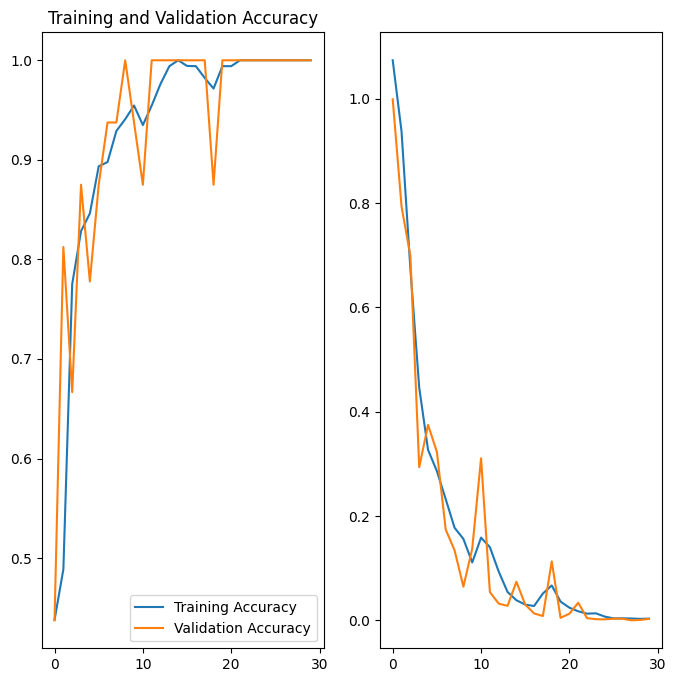

In [21]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(30), acc, label='Training Accuracy')
plt.plot(range(30), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(30), loss, label='Training Loss')
plt.plot(range(30), val_loss, label='Validation Loss')
plt.show()

Actual Label:  Bacterial
1/1 [==============================] - 0s 124ms/step
Predicted Label:  Bacterial


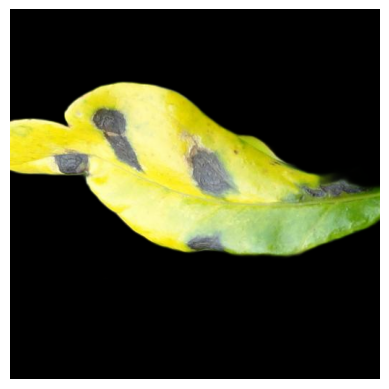

In [22]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    plt.imshow(first_image)
    print("Actual Label: ", class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("Predicted Label: ", class_names[np.argmax(batch_prediction[0])])
    plt.axis("off")

In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [24]:
len(test_ds)

2

1/1 [==============================] - 0s 23ms/step


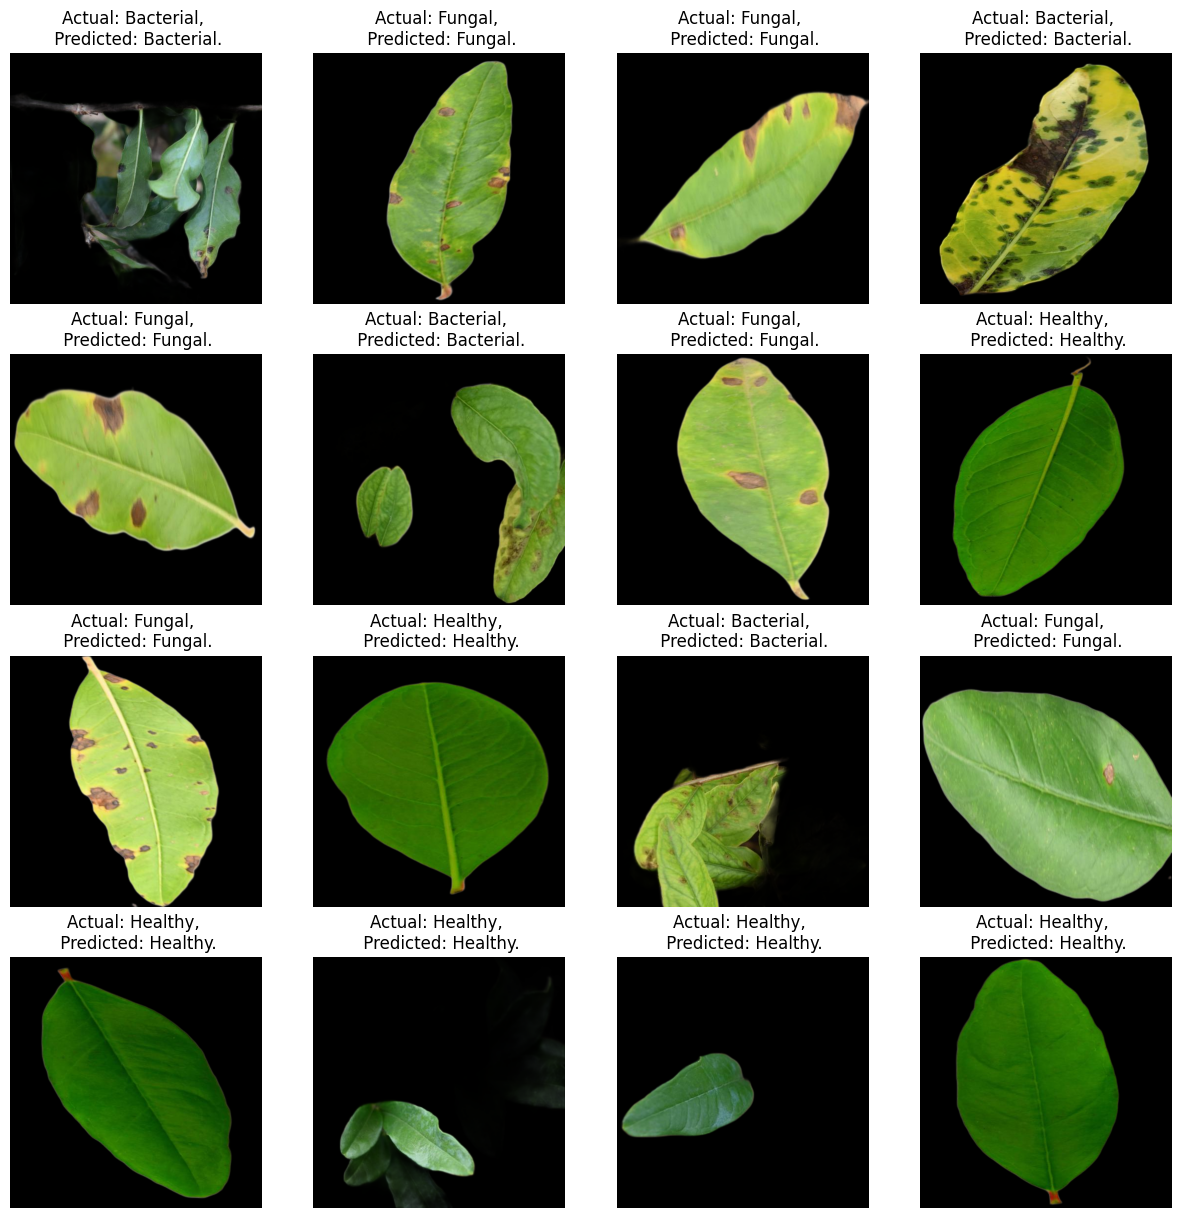

In [25]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.")
        plt.axis("off")